In this post we study the Regularized Bayesian Regression model to explore and compare the weight and function space and views of Gaussian Process Regression as described in the book [Gaussian Processes for Machine Learning, Ch 2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf). We follow this reference very closely (and encourage to read it!). Our main objective is to ilustrate the concepts and results through a concrete example. We use [PyMC3](https://docs.pymc.io) to run bayesian sampling. 

**References:**

- [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf), Carl Edward Rasmussen and Christopher K. I. Williams, MIT Press, 2006.
- See [this](https://juanitorduz.github.io/intro_pymc3/) post for an introduction to bayesian methods and PyMC3.
- [Documentation](https://docs.pymc.io/notebooks/GLM-linear.html) of linear regression in PyMC3. 
- [Documentation](https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.MvNormal) for the multivariate normal distribution in PyMC3. 
- [Here](https://stackoverflow.com/questions/52509602/cant-compile-c-program-on-a-mac-after-upgrade-to-mojave) is an Stackoverflow post which can help Mac OS users which might have problems with Theano after upgrading to Mojave. 

Let us consider the model:

$$
f(x) = x^T b \quad \text{and} \quad y = f(x) + \varepsilon, \quad \text{with} \quad \varepsilon \sim N(0, \sigma_n^2)
$$

where \\(x \in \mathbb{R}^d\\) is a vector of data and \\(b \in \mathbb{R}^d\\) is the vector of weights (parameters). We assume a bias weight (i.e. intercept) is included in \\(b\\).  

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Sample Data

Let us begin by generating sample data.

In [2]:
# Define dimension.
d = 2

# Number of samples. 
n = 100

# Independent variable. 
x = np.linspace(start=0, stop=1, num=n).reshape([1, n])

# Design matrix. We add a column of ones to account for the bias term. 
X = np.append(np.ones(n).reshape([1, n]), x, axis=0)

Now we generate the response variable.

In [3]:
# True parameters. 
b = np.zeros(d)
## Intercept. 
b[0] = 1
## Slope. 
b[1] = 3

b = b.reshape(d, 1)

# Error standar deviation. 
sigma_n = 0.5

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n).reshape([n, 1])

f = np.dot(X.T, b)

# Observed target variable. 
y = f + epsilon

We visualize the data set.

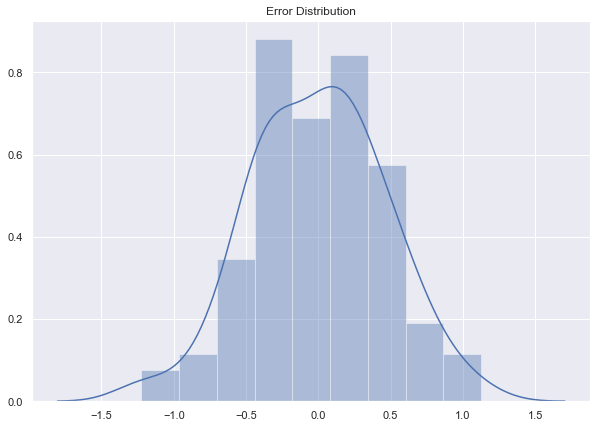

In [42]:
plt.rcParams['figure.figsize'] = (10,7)

fig, ax = plt.subplots()
sns.distplot(epsilon, ax=ax)
ax.set_title('Error Distribution');

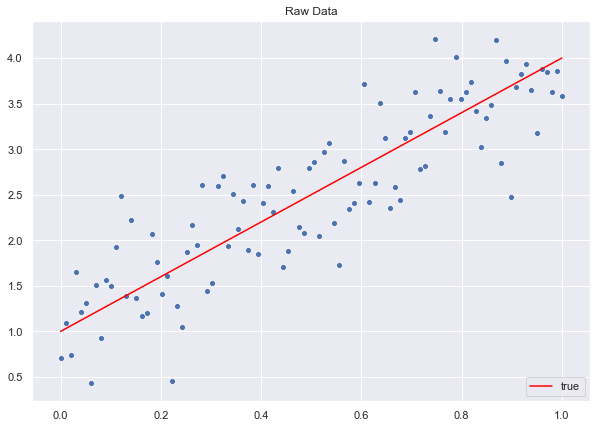

In [43]:
fig, ax = plt.subplots()
# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');

ax.set(title='Raw Data')
ax.legend(loc='lower right');

## Likehood

A straightforward calculation shows that the likehood function is given by

$$
p(y|X, b) = 
\prod_{i=1}^{n} p(y_i|x_i, b)
=
\frac{1}{(2\pi \sigma_n^2)^{n/2}} \exp\left(-\frac{1}{2\sigma_n^2}||y - X^T b||^2\right) = 
N(X^T b, \sigma_n^2 I)
$$

where $X\in M_{d\times n}(\mathbb{R})$ is the design matrix which has the observations as rows.

## Prior Distribution

We set a multivariate normal distribution with mean zero for the prior of the vector of weights \\(b \sim N(0, \Sigma_p)\\). Here \\(\Sigma_p \in M_{d}(\mathbb{R})\\) denotes the covariance matrix. 

In [11]:
# Mean vector.
mu_0 = np.zeros(d)
# Covariance matrix. 
# Add small perturbation for numerical stability. 
sigma_p = np.array([[2, 1], [1, 2]]) + 1e-12*np.eye(d)

sigma_p

array([[2., 1.],
       [1., 2.]])

Let us sample from the prior distribution to see the level curves (see [this](https://juanitorduz.github.io/multivariate_normal/) post). 

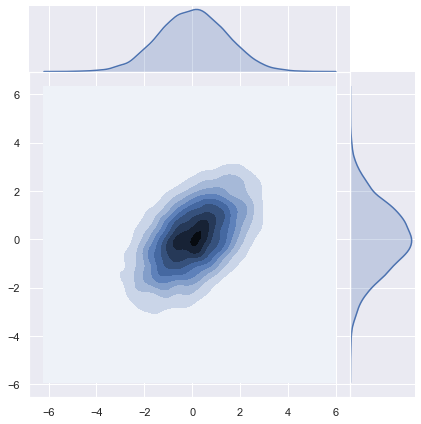

In [13]:
# Set number of samples. 
m = 10000
# Generate samples. 
z = np.random.multivariate_normal(mean=mu_0, cov=sigma_p, size=m)
z = z.T
# PLot. 
sns.jointplot(x=z[0], y=z[1], kind="kde", space=0);

Note that the ellipse-like level curves are rotated (with respect the natural axis) due the fact that \\(\Sigma_p\\) is not diagonal. 

Let us begin by sampling lines from the prior distribution. 

In [15]:
# Number of samples to select. 
m = 200
# Sample from prior distribution of the weight vector.
z_prior = np.random.multivariate_normal(mean=mu_0, cov=sigma_p, size=m)
# Compute prior lines. 
lines_prior = np.dot(z_prior, X)

We visualize the sample lines.

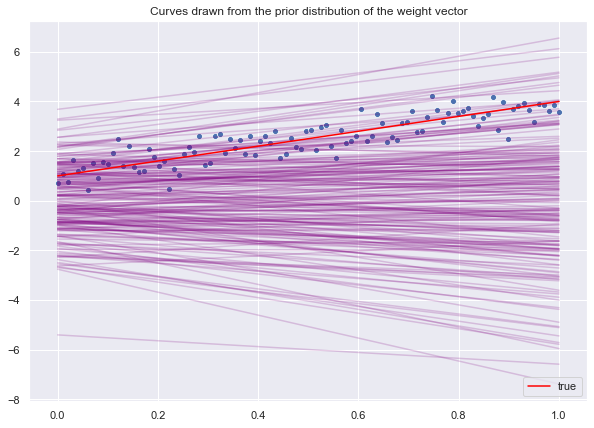

In [46]:
fig, ax = plt.subplots()

# Loop over the line samples from the prior distribution.
for i in range(0, m):

    sns.lineplot(
        x=x.T.flatten(), 
        y=lines_prior[i], 
        color='purple', 
        alpha=0.2
    )

# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');

ax.set(title='Curves drawn from the prior distribution of the weight vector')
ax.legend(loc='lower right');

## Posterior Distribution

Now we want to use the data to find the posterior destribution of the vector of weights. Recall that the posterior is obtained (from Bayes rule) by computing 

$$
\text{posterior} =
\frac{\text{likelihood × prior}}{\text{marginal likelihood}}
$$

Concretely, 

$$
p(b|y, X) = 
\frac{p(y|X, b)p(b)}{p(y|X)}
$$

The marginal likehood \\(p(y|X)\\), which is independent of \\(b\\), is calculated as 

$$
p(y|X) = \int p(y|X, b)p(b) db
$$

### MCMC Sampling with PyMC3

Recall that we do not need to compute \\(p(y|X)\\) directly since we can sample from the posterior distribution using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling. Again, see [this](https://juanitorduz.github.io/intro_pymc3/) post for more details. 

In [23]:
import theano.tensor as tt

model = pm.Model()

with model:
    # Define prior.
    beta = pm.MvNormal('beta', mu=mu_0, cov=sigma_p, shape=d)
    # Define likelihood.
    likelihood = pm.Normal('y', mu=tt.dot(X.T, beta), sd=sigma_n, observed=y.squeeze())
    # Consider 6000 draws and 3 chains.
    trace = pm.sample(draws=7500, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta]
Sampling 3 chains: 100%|██████████| 24000/24000 [00:10<00:00, 2342.95draws/s]


Let us visualize the posterior distributions. 

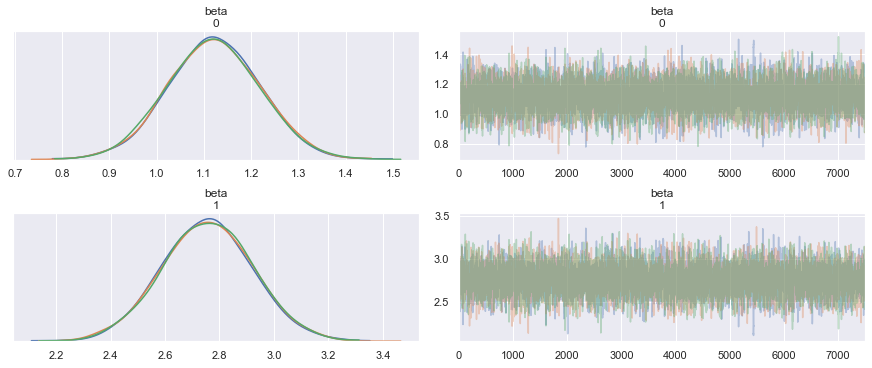

In [24]:
pm.traceplot(trace, figsize=(12, 5));

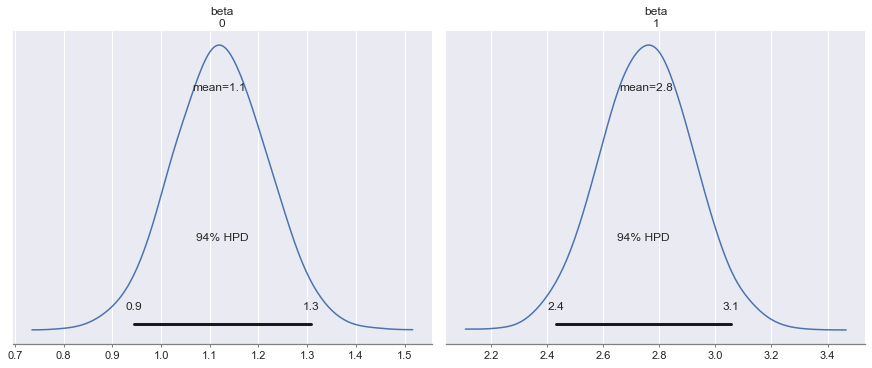

In [25]:
pm.plot_posterior(trace, figsize=(12, 5));

In [26]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,1.119707,0.096479,0.001209,0.932449,1.310260,5724.154424,1.000021
beta__1,2.752970,0.165452,0.002037,2.423543,3.075115,5847.177460,1.000040


Let us see the join posterior distribution. 

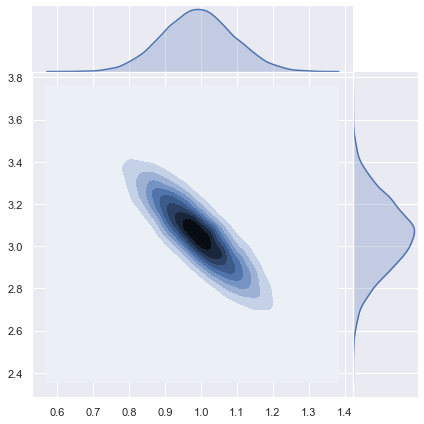

In [57]:
sns.jointplot(x=trace['beta'].T[0],y=trace['beta'].T[1], kind='kde', space=0);

Now let us sample from the posterior distribution.

In [27]:
# Get a sub-sammple of indices of length m. 
sample_posterior_indices = np.random.choice(trace["beta"].shape[0], m, replace=False)
# Select samples from the trace of the posterior. 
z_posterior = trace["beta"][sample_posterior_indices, ]
# Compute posterior lines. 
lines_posterior = np.dot(z_posterior, X)

Similarly, let us plot the posterior samples. 

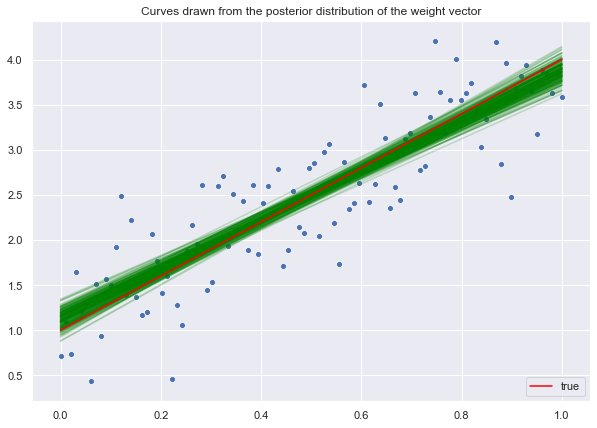

In [47]:
fig, ax = plt.subplots()

# Loop over the line samples from the posterior distribution.
for i in range(0, m):

    sns.lineplot(
        x=x.T.flatten(), 
        y=lines_posterior[i], 
        color='green', 
        alpha=0.2
    )
    
# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');

ax.set(title='Curves drawn from the posterior distribution of the weight vector')
ax.legend(loc='lower right');

We see how the data makes the posterior distribution much more localized around the mean. 

## Predictions

Next, we use the posterior distribution of the weights vector to generate predictions. 

### Parameter Mean

Let us begin by using the mean of the posterior distribution of each parameter to find the linear fit.

In [48]:
# Compute mean of the posterior distribution. 
beta_hat = np.apply_over_axes(func=np.mean, a=trace['beta'], axes=0).reshape(d,1)
# Compute lineear fit. 
y_hat = np.dot(X.T, beta_hat)

Let us plot the result. 

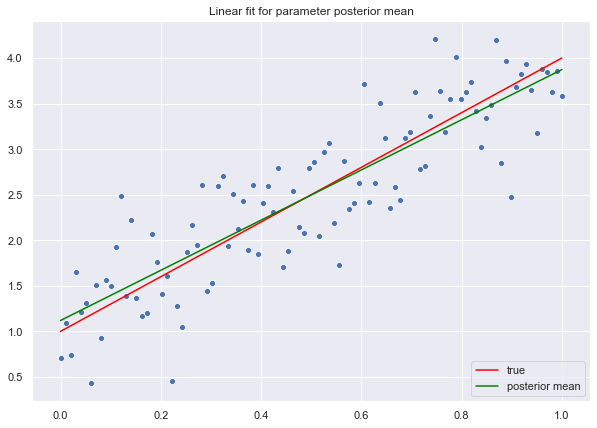

In [54]:
fig, ax = plt.subplots()
# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');
# Plot line corresponding to the posterior mean of the weight vector. 
sns.lineplot(x=x.T.flatten(), y=y_hat.flatten(), color='green', label='posterior mean');

ax.set(title='Linear fit for parameter posterior mean')
ax.legend(loc='lower right');

### Confidence Inteval 

Next, let us compute the confidence interval for the fit. 

In [51]:
# We sample from the posterior. 
y_hat_samples = np.dot(X.T, trace['beta'].T)

In [52]:
# Compute the standard deviation. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

Let us plot the confidence interval corrsponding to a corridor coresponding to two standard deviations. 

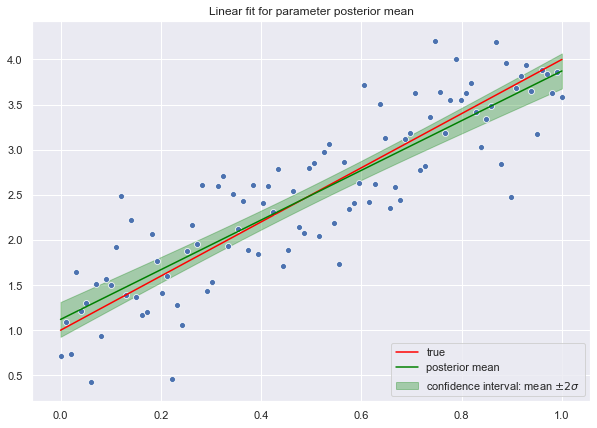

In [63]:
fig, ax = plt.subplots()

# Plot confidence interval.
plt.fill_between(
    x=x.T.reshape(n,), 
    y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
    y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
    color = 'green', 
    alpha = 0.3, 
    label='confidence interval: mean $\pm 2 \sigma$'
)

# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');
# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot line corresponding to the posterior mean of the weight vector. 
sns.lineplot(x=x.T.flatten(), y=y_hat.flatten(), color='green', label='posterior mean');

ax.set(title='Linear fit for parameter posterior mean');
ax.legend(loc='lower right');

### Test Set

Now, we write a function to generate predictions for a new data point. 

In [64]:
def generate_prediction(x_star, trace):
    """
    Generate prediction for a new value given the 
    posterior distribution()
    """
    # Compute prediction distribution. 
    prob = np.dot(x_star.T, trace['beta'].T)
    # Sample from it. 
    y_hat = np.random.choice(a=prob.squeeze())
    
    return y_hat

Let us generate a prediction for the value \\(z_* = 0.85\\)

In [68]:
z_star = np.array([[1], [0.85]])

y_hat_star = generate_prediction(z_star, trace)

y_hat_star

3.4665727031987528

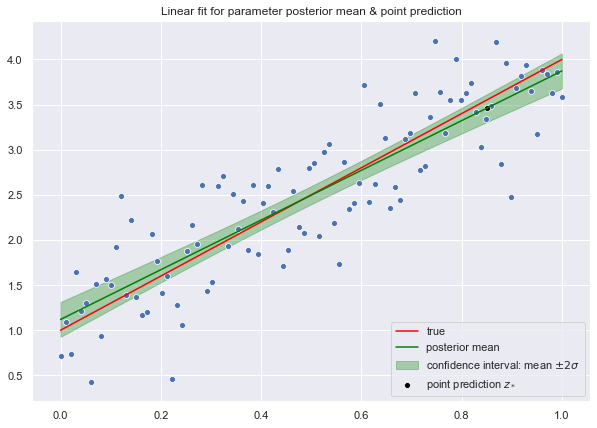

In [72]:
fig, ax = plt.subplots()

# Plot confidence interval.
plt.fill_between(
    x=x.T.reshape(n,), 
    y1=(y_hat.reshape(n,) - 2*y_hat_sd), 
    y2=(y_hat.reshape(n,) + 2*y_hat_sd), 
    color = 'green', 
    alpha = 0.3, 
    label='confidence interval: mean $\pm 2 \sigma$'
)

# Plot "true" linear fit.
sns.lineplot(x=x.T.flatten(), y=f.flatten(), color='red', label='true');
# Plot raw data.
sns.scatterplot(x=x.T.flatten(), y=y.flatten());
# Plot line corresponding to the posterior mean of the weight vector. 
sns.lineplot(x=x.T.flatten(), y=y_hat.flatten(), color='green', label='posterior mean');
# Point prediction
sns.scatterplot(x=z_star[1], y=y_hat_star, color='black', label='point prediction $z_*$');

ax.set(title='Linear fit for parameter posterior mean & point prediction');
ax.legend(loc='lower right');

## Analytical Solution

We can find the analytical solution of the posterior distribution. 

$$
p(b|y, X) \propto 
\exp\left(
-\frac{1}{2\sigma_n^2}||y - X^T b||^2
\right)
\exp\left(
-\frac{1}{2} b^T \Sigma_p b
\right)
$$

We can "complete the square" to do it. Specifically, let us define:

$$
A:= \sigma_n^{-2}XX^T + \Sigma_p^{-1} \in M_{d}(\mathbb{R})
\quad
\text{and}
\quad
\bar{b}:= \sigma_n^{-2}A^{-1}Xy
$$

Then, 

$$
\sigma_n^{-2} ||y - X^T b||^2 + b^T \Sigma_p b
=
b^T A b - \sigma_n^{-2}(b^T Xy + (b^T Xy)^T) + \sigma_n^{-2}y^Ty.
$$

The last term does not depend on \\(b\\) so we can ignore it for the calculation. Observe that \\(\sigma_n^{-2} b^T Xy = \sigma_n^{-2} b^TAA^{-1}Xy = b^TA\bar{b}\\), hence 

$$
b^T A b - \sigma_n^{-2}(b^T Xy + (b^T Xy)^T) = 
b^T A b - b^TA\bar{b} - \bar{b}^TAb =
b^T A b - b^TA\bar{b} - \bar{b}^TAb =
(b - \bar{b})^TA(b - \bar{b}) - \bar{b}^TA\bar{b} 
$$

Again, the therm \\(\bar{b}^TA\bar{b}\\) does not depend on \\(b\\), so it is not relevant for the computation. We *then recognize the form of the posterior distribution as gaussian with mean \\(\bar{b}\\) and covariance matrix \\(A^{-1}\\).*

$$
p(b|y, X) \sim N
\left(
\frac{1}{\sigma_n^2} A^{-1}Xy, 
A^{-1}
\right)
$$

Let us compute the analytic solution for this example:

In [58]:
# Compute A.
A = (sigma_n)**(-2)*np.dot(X, X.T) + np.linalg.inv(sigma_p)
# Compute its inverse. 
A_inv = np.linalg.inv(A)

In [59]:
# Compute b_bar.
b_bar = (sigma_n)**(-2)*np.dot(A_inv, np.dot(X, y))
b_bar

array([[0.99212616],
       [3.05275344]])

Note that these values coincide with the values above obtained from the MCMC sampling. Let us sample from the analytical solution of the posterior distribution.

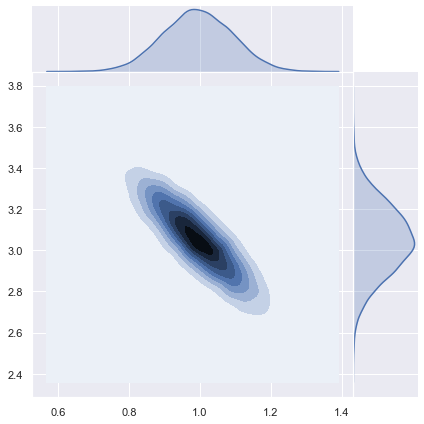

In [60]:
m = 10000

z = np.random.multivariate_normal(mean=b_bar.squeeze(), cov=A_inv, size=m)

z = z.T

sns.jointplot(x=z[0], y=z[1], kind='kde', space=0);

These level curves coinncide with the ones obtained above. 

Predictive distribution

$$
p(y_*|z_*, X, y) = N\left(\frac{1}{\sigma_n^2}x_*^T A^{-1}Xy, x_*^TA^{-1}x_*\right)
$$

## Regularized Bayesian Linear Regression as a Gaussian Process 

A **gaussian process** is a collection of random variables, any finite number of which have a joint gaussian distribution (See  [Gaussian Processes for Machine Learning, Ch2 - Section 2.2](http://www.gaussianprocess.org/gpml/chapters/RW2.pdf)).

A Gaussian process \\(f(x) \\) is completely specified by its mean function \\(m(x)\\) and covariance function \\(k(x, x')\\). Here \\(x \in \mathcal{X}\\) denotes a point on the index set \\(\mathcal{X}\\). These functions are defined by

$$
m(x) = E[f(x)]
\quad
\text{and}
\quad
k(x, x') = E[(f(x) - m(x))(f(x') - m(x'))]
$$

**Claim:** The map \\(f(x) = x^T b \\) defines a Gaussian process. 

*Proof:*

1. Let \\(x_1, \cdots, x_N \in \mathcal{X}=\mathbb{R}^d\\). As \\(b\\) has a multivariate normal distribution, then every linear combination of its components is normally distributed (see [here](https://juanitorduz.github.io/multivariate_normal/)). In particular, for any \\(a_1, \cdots, a_N \in \mathbb{R}\\), we see that 

$$
\sum_{i=1}^N a_i f(x_i)
=
\sum_{i=1}^N a_i x_i^Tb
=
\left(\sum_{i=1}^N a_i x_i\right)^Tb
$$

is a linear combination of the components of \\(b\\), thus is normally distributed. This shows that \\(f(x)\\) is a gaussian process. 

Let us now compute the mean and covariance functions:

2. \\(m (x) = E[f(x)] = x^T E[b]\\) = 0.


3. \\(k(x, x') = E[f(x)f(x')] = E[x^T b (x')^T b] = E[x^T b b^T x'] = x^T E[bb^T]x' = x^T \Sigma_px'\\).

## Function-Space View

We can understand a gaussian process, and in particular a regularized bayesian regression, as an inference directly in function space (see details on a later post). 

In [74]:
n_star = 80

x_star = np.linspace(start=0, stop=1, num=n_star).reshape([1, n_star])

X_star = np.append(np.ones(n_star).reshape([1, n_star]), x_star, axis=0)

In [75]:
def kernel(x_1, x_2, k):
    """Kernel function."""
    z = np.dot(x_1.T, k)
    
    return np.dot(z, x_2)

In [76]:
cov_prior = kernel(X_star, X_star, sigma_p)

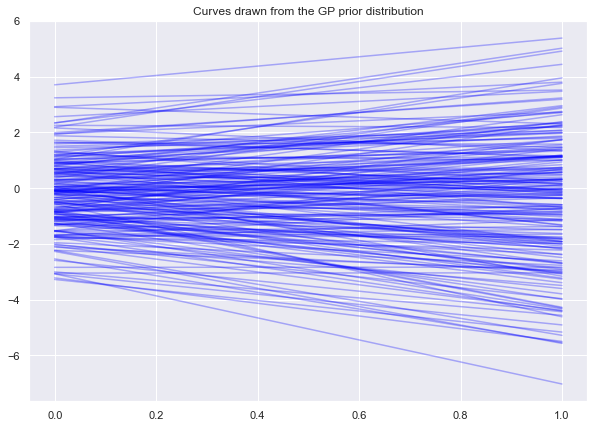

In [77]:
# Number of samples to select. 
m = 200

fig, ax = plt.subplots()

for i in range(0, m):
    
    points_sample = np.random.multivariate_normal(
        mean=np.zeros(n_star), 
        cov=cov_prior
    )
    
    sns.lineplot(
        x=x_star.flatten(), 
        y=points_sample, 
        color='blue', 
        alpha=0.3, 
        ax=ax
    )

ax.set(title='Curves drawn from the GP prior distribution');

In [78]:
K = kernel(X, X, sigma_p)
K_star = kernel(X_star, X, sigma_p)
K_star_star = kernel(X_star, X_star, sigma_p)

In [79]:
mean_posterior = np.dot(np.dot(K_star, np.linalg.inv(K + sigma_n**2*np.eye(n))), y)

cov_posterior = K_star_star - np.dot(np.dot(K_star, np.linalg.inv(K + sigma_n**2*np.eye(n))), K_star.T)

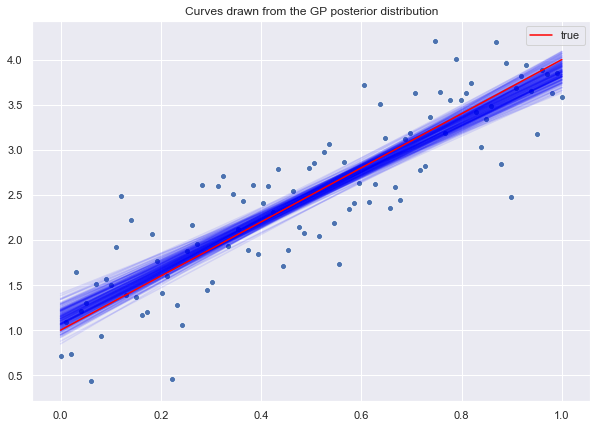

In [81]:
# Number of samples to select. 
m = 200

fig, ax = plt.subplots()

for i in range(0, m):
    
    points_sample = np.random.multivariate_normal(
        mean=mean_posterior.flatten(),
        cov=cov_posterior
    )
    
    sns.lineplot(
        x=x_star.flatten(), 
        y=points_sample, 
        color='blue', 
        alpha=0.1, 
        ax=ax
    )
    
# Plot raw data.
sns.scatterplot(x=x.T.reshape(n,), y=y.reshape(n,), ax=ax);
# Plot "true" linear fit.
sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color='red', label='true', ax=ax);

ax.set_title('Curves drawn from the GP posterior distribution');